In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, model_selection, ensemble, linear_model

In [2]:
df = pd.read_csv("../data/AB_NYC_2019.csv")
print("Dimensions of the data: " + str(df.shape[0]) + " and " + str(df.shape[1])) 

Dimensions of the data: 48895 and 16


# DATA ANALYSIS

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [4]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
df.dtypes
#Dependent variable: price

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [7]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [8]:
top_host=df.host_id.value_counts().head(10)
top_host

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
16098958      96
61391963      91
22541573      87
200380610     65
7503643       52
Name: host_id, dtype: int64

In [9]:
#setting figure size for future visualizations
sns.set(rc={'figure.figsize':(10,8)})

[Text(0, 0, '219517861'),
 Text(0, 0, '107434423'),
 Text(0, 0, '30283594'),
 Text(0, 0, '137358866'),
 Text(0, 0, '12243051'),
 Text(0, 0, '16098958'),
 Text(0, 0, '61391963'),
 Text(0, 0, '22541573'),
 Text(0, 0, '200380610'),
 Text(0, 0, '7503643')]

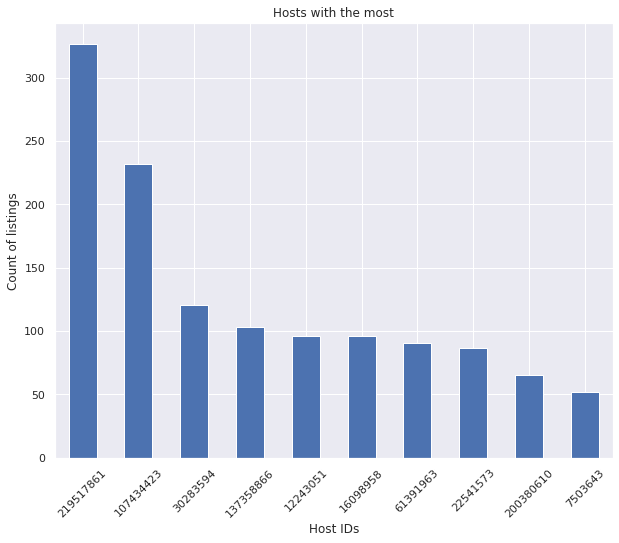

In [10]:
viz_1=top_host.plot(kind="bar")
viz_1.set_title("Hosts with the most")
viz_1.set_ylabel("Count of listings")
viz_1.set_xlabel("Host IDs")
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

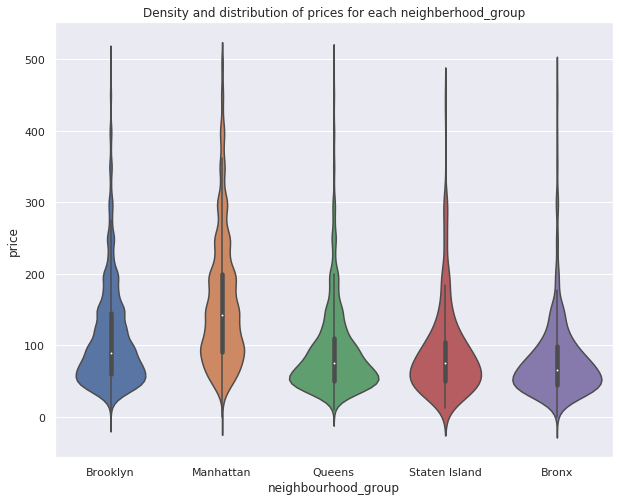

In [13]:
sub_1=df[df.price < 500]
viz_2=sns.violinplot(data=sub_1, x='neighbourhood_group', y='price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')

In [14]:
df.neighbourhood.value_counts().head(10)

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: neighbourhood, dtype: int64

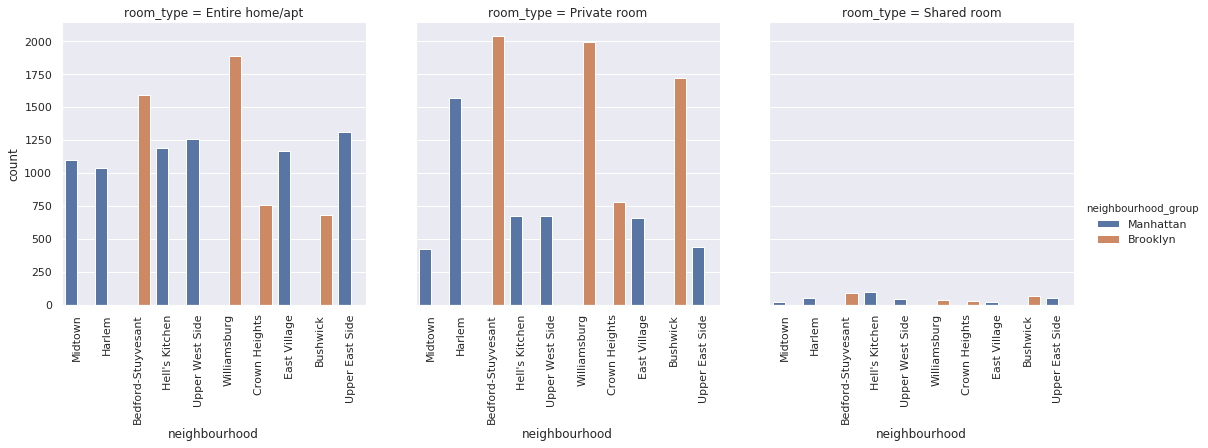

In [15]:
neighbourhood_lst = list(df.neighbourhood.value_counts().head(10).index)
sub_2=df.loc[df['neighbourhood'].isin(neighbourhood_lst)]

viz_3=sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=sub_2, kind='count')
viz_3.set_xticklabels(rotation=90)

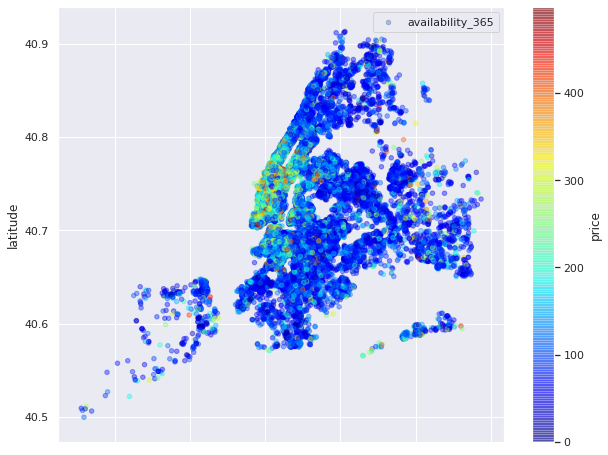

In [16]:
viz_4=sub_1.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price',
                 cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))
viz_4.legend()

In [17]:
top_reviewed_listings=df.nlargest(10,'number_of_reviews')
top_reviewed_listings

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
11759,9145202,Room near JFK Queen Bed,47621202,Dona,Queens,Jamaica,40.66730,-73.76831,Private room,47,1,629,2019-07-05,14.58,2,333
2031,903972,Great Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82085,-73.94025,Private room,49,1,607,2019-06-21,7.75,3,293
2030,903947,Beautiful Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82124,-73.93838,Private room,49,1,597,2019-06-23,7.72,3,342
2015,891117,Private Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82264,-73.94041,Private room,49,1,594,2019-06-15,7.57,3,339
13495,10101135,Room Near JFK Twin Beds,47621202,Dona,Queens,Jamaica,40.66939,-73.76975,Private room,47,1,576,2019-06-27,13.40,2,173
10623,8168619,Steps away from Laguardia airport,37312959,Maya,Queens,East Elmhurst,40.77006,-73.87683,Private room,46,1,543,2019-07-01,11.59,5,163
1879,834190,Manhattan Lux Loft.Like.Love.Lots.Look !,2369681,Carol,Manhattan,Lower East Side,40.71921,-73.99116,Private room,99,2,540,2019-07-06,6.95,1,179
20403,16276632,Cozy Room Family Home LGA Airport NO CLEANING FEE,26432133,Danielle,Queens,East Elmhurst,40.76335,-73.87007,Private room,48,1,510,2019-07-06,16.22,5,341
4870,3474320,Private brownstone studio Brooklyn,12949460,Asa,Brooklyn,Park Slope,40.67926,-73.97711,Entire home/apt,160,1,488,2019-07-01,8.14,1,269
471,166172,LG Private Room/Family Friendly,792159,Wanda,Brooklyn,Bushwick,40.70283,-73.92131,Private room,60,3,480,2019-07-07,6.70,1,0


In [18]:
price_avrg=top_reviewed_listings.price.mean()
print('Average price per night: {}'.format(price_avrg))

Average price per night: 65.4


# FEATURE ENGINEERING

In [19]:
#Id, name, host_id, host_name are not important
df = df.drop(["id","name","host_id","host_name","latitude","longitude"],axis=1)

In [20]:
type_set=set()
for i in range(len(df.dtypes)):
    type_set.add(df.dtypes[i])
print(type_set)

{dtype('int64'), dtype('float64'), dtype('O')}


In [21]:
df.fillna({'reviews_per_month':0}, inplace=True) #1
df.dropna(inplace=True)

In [22]:
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [23]:
df.drop(df[df["price"]==0].index,axis=0, inplace=True)
# df.drop(df[df["price"]>250].index,axis=0, inplace=True)
ml_df = df.copy()

In [24]:
df["year"] = df["last_review"].str[:4]
df["year"] = df["year"].astype("int32")
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,year
0,Brooklyn,Kensington,Private room,149,1,9,2018-10-19,0.21,6,365,2018
1,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2019
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,2019
4,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,2018
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,2019


In [25]:
# Init a new column
df["part_of_year"] = "Q"

month = df["last_review"].str[5:7]

q1=["01","02","03"]
q2=["04","05","06"]
q3=["07","08","09"]
q4=["10","11","12"]

q = [q1,q2,q3,q4]

# Update the column
for i in range(len(q)):
    df.loc[month.isin(q[i]), "part_of_year"] = "Q{}".format(i+1)
    
# Create review category    
df["review_bin"] = pd.qcut(df["number_of_reviews"],
                          q=[0,.2,.4,.6,.8,1])


# df["price_bin"] = pd.qcut(df["price"],
#                           q=[0,.2,.4,.6,.8,1])

In [26]:
df.shape

(38833, 13)

In [27]:
columns_to_change=["neighbourhood",'neighbourhood_group',"room_type","part_of_year","review_bin"]
columns_to_drop = ["last_review","calculated_host_listings_count",
                   "availability_365","reviews_per_month","number_of_reviews"]
columns_to_change.extend(columns_to_drop)

df.drop(columns_to_drop,axis=1,inplace=True, errors="ignore")

for i in range(len(columns_to_change)):
    try:
        df = pd.concat([df,pd.get_dummies(df[columns_to_change[i]], prefix=columns_to_change[i])],axis=1)
        print("Column {} has been removed from the df.".format(columns_to_change[i]))
    except KeyError:
        print("Column {} is not in the df (anymore).".format(columns_to_change[i]))

df.drop(columns_to_change,axis=1,errors='ignore', inplace=True)

df.head()

Column neighbourhood has been removed from the df.
Column neighbourhood_group has been removed from the df.
Column room_type has been removed from the df.
Column part_of_year has been removed from the df.
Column review_bin has been removed from the df.
Column last_review is not in the df (anymore).
Column calculated_host_listings_count is not in the df (anymore).
Column availability_365 is not in the df (anymore).
Column reviews_per_month is not in the df (anymore).
Column number_of_reviews is not in the df (anymore).


,price,minimum_nights,year,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,...,room_type_Shared room,part_of_year_Q1,part_of_year_Q2,part_of_year_Q3,part_of_year_Q4,"review_bin_(0.999, 2.0]","review_bin_(2.0, 6.0]","review_bin_(6.0, 15.0]","review_bin_(15.0, 44.0]","review_bin_(44.0, 629.0]"
0,149,1,2018,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,225,1,2019,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,89,1,2019,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,80,10,2018,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5,200,3,2019,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [28]:
df.shape

(38833, 238)

In [29]:
df.columns

Index(['price', 'minimum_nights', 'year', 'neighbourhood_Allerton',
       'neighbourhood_Arden Heights', 'neighbourhood_Arrochar',
       'neighbourhood_Arverne', 'neighbourhood_Astoria',
       'neighbourhood_Bath Beach', 'neighbourhood_Battery Park City',
       ...
       'room_type_Shared room', 'part_of_year_Q1', 'part_of_year_Q2',
       'part_of_year_Q3', 'part_of_year_Q4', 'review_bin_(0.999, 2.0]',
       'review_bin_(2.0, 6.0]', 'review_bin_(6.0, 15.0]',
       'review_bin_(15.0, 44.0]', 'review_bin_(44.0, 629.0]'],
      dtype='object', length=238)

In [30]:
x_data = df.drop("price",axis=1)
y_data = df["price"]
print(x_data.shape)
print(y_data.shape)

X_train, X_holdout, y_train, y_holdout = model_selection.train_test_split(x_data, 
                                                                          y_data,
                                                                          test_size=0.2,
                                                                          random_state=42)

print(X_train.shape)

(38833, 237)
(38833,)
(31066, 237)


In [31]:
names = X_train.columns
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=names)

In [32]:
# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))

In [33]:
reg = linear_model.LinearRegression().fit(X_train,y_train)
reg.score(X_holdout,y_holdout)

-411386753162.3344

In [34]:
scores = []

regressor = ensemble.RandomForestRegressor(n_estimators=100,random_state=42,verbose=1)
model = regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.2s finished


In [35]:
model.score(X_holdout, y_holdout)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.04707651160719961

In [36]:
ml_df.drop(['host_name','name'], axis=1, inplace=True, errors="ignore")
ml_df.shape

(38833, 10)

In [37]:
ml_df[ml_df['number_of_reviews']== 0.0].shape


(0, 10)

In [38]:
ml_df['last_review'] = pd.to_datetime(ml_df['last_review'],infer_datetime_format=True) 

In [39]:
earliest = min(ml_df['last_review'])
ml_df['last_review'] = ml_df['last_review'].fillna(earliest)
ml_df['last_review'] = ml_df['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [40]:
total = ml_df.isnull().sum().sort_values(ascending=False)
percent = (ml_df.isnull().sum())/ml_df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
neighbourhood,0,0.0
neighbourhood_group,0,0.0


In [41]:
import statsmodels
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

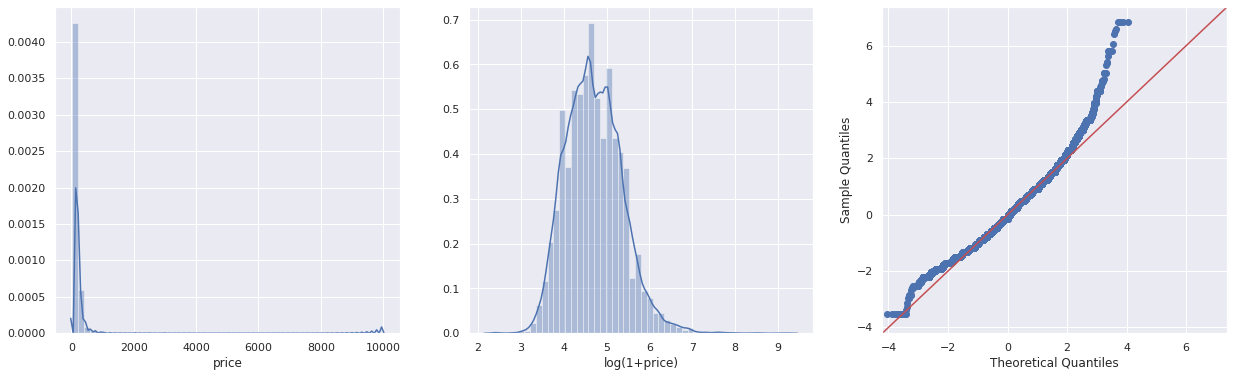

In [42]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(ml_df['price'], ax=axes[0])
sns.distplot(np.log1p(ml_df['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(ml_df['price']), stats.norm, fit=True, line='45', ax=axes[2]);

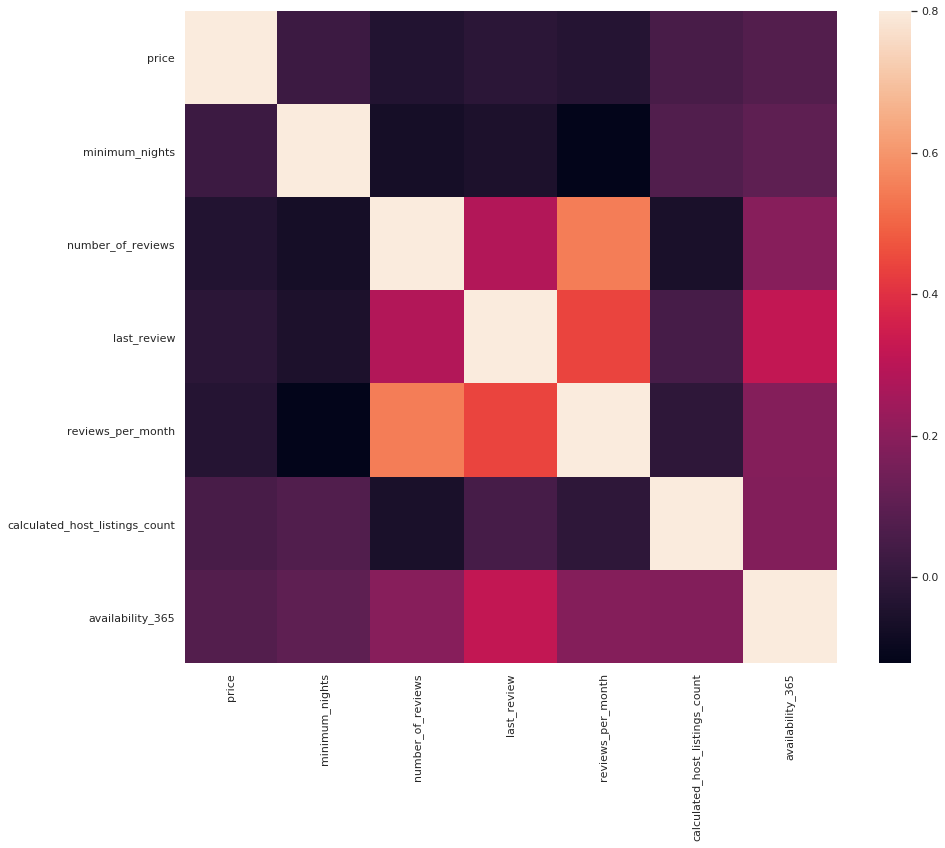

In [43]:
corrmatrix = ml_df.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

In [44]:
categorical_features = ml_df.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (38833, 3)


In [45]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
ml_df['reviews_per_month'] = ml_df['reviews_per_month'].fillna(0)

In [47]:
numerical_features =  ml_df.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (38833, 6)


In [48]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [49]:
Processed_data = pd.concat([X_df, y], axis = 1)
Processed_data.to_csv('NYC_Airbnb_Processed.dat')

In [50]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [52]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [53]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

In [54]:
# for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
#     if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
#     else: cv_res = rmse_cv(Model())
#     print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

In [55]:
# rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42,verbose=True))
# print(1)
# rfr_baseline = RandomForestRegressor(random_state=42,verbose=True)
# print(2)
# rfr_baseline.fit(X_train, y_train) 
# print(3)
# y_train_rfr = rfr_baseline.predict(X_train)
# print(4)
# y_test_rfr = rfr_baseline.predict(X_test)
# print(5)
# rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
#             'CV error': rfr_CV_baseline.mean(), 
#             'CV std': rfr_CV_baseline.std(),
#             'training error': [mean_squared_error(y_train_rfr, y_train)],
#             'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [56]:
import pprint as pprint

In [57]:
# rf = RandomForestRegressor(random_state=42)

# #Number of trees in the forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# max_depth.append(None)
# min_samples_split = [2,5,10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators,
#         'max_features': max_features,
#         'max_depth': max_depth,
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'bootstrap': bootstrap}

# # pprint(random_grid)

# rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

# rf_random.fit(X_train, y_train)

In [58]:
best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,30929.346786,7364.267518,13293.322383,34375.777437,0.65144,0.169733


In [60]:
import pickle

In [61]:
filename = 'finalized_model.sav'
pickle.dump(best_random, open(filename, 'wb'))

# Notes from other notebooks
https://www.kaggle.com/dgomonov/data-exploration-on-nyc-airbnb
Very good visualizations 

https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations
Model building

In [63]:
X_test.shape

(7767, 232)